# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
#!pip install scipy
#!pip install imageio
#!pip install scikit-image  # lazy-loader-0.4 networkx-3.3 scikit-image-0.24.0 tifffile-2024.7.24
#!pip install opencv-python # opencv-python-4.10.0.84
#!pip install keras.layers.convolutional
#!pip install keras==2.15.0 #keras-2.15.0
#!pip install tensorflow  

In [1]:
import numpy as np
#from scipy.misc import imread, imresize
#import imageio
from skimage import io
from skimage.transform import resize
from skimage.util import crop
import matplotlib.pyplot as plt

import datetime
import os

In [2]:
from keras.layers import Dense, Activation, Dropout, Conv2D, LSTM, MaxPooling2D, Flatten, BatchNormalization, Conv3D, MaxPooling3D, Input

In [3]:
import pandas as pd

In [4]:
import imageio.v2 as imageio

In [ ]:
#Commenting google colab code
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!ls /content/drive/MyDrive/DataSets/

In [ ]:
#!unzip /content/drive/MyDrive/DataSets/Project_data.zip -d /content/drive/MyDrive/DataSets/

We set the random seed so that the results don't vary drastically.

In [ ]:
#!pip install rasa==1.1.4

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30) --> Deprecated
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
localExecution = True

In [7]:
if localExecution:
    dataset_path = "C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data/"
    model_checkpoint_path = "C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/"
else:
    dataset_path = '/home/datasets/Project_data/'  # Jarvis lab
    model_checkpoint_path = './'


In [17]:
#!cp -r /home/datasets/Project_data /home/datasets/Project_data_partial

In [18]:
#!mkdir /content/drive/MyDrive/DataSets/Project_data_partial/train_15/
#!mv /content/drive/MyDrive/DataSets/Project_data_partial/train/WIN_20180907_15_*  /content/drive/MyDrive/DataSets/Project_data_partial/train_15/

In [ ]:
#!mkdir /content/drive/MyDrive/DataSets/Project_data_partial/val_15/
#!mv /content/drive/MyDrive/DataSets/Project_data_partial/val/WIN_20180907_15* /content/drive/MyDrive/DataSets/Project_data_partial/val_15/

In [ ]:
#!ls -l /content/drive/MyDrive/DataSets/Project_data_partial/train_15/ | wc -l
#!ls -l /content/drive/MyDrive/DataSets/Project_data_partial/val_15/ | wc -l

In [8]:
train_csv = dataset_path+'/train.csv'
val_csv = dataset_path+'/val.csv'

In [9]:
train_df = pd.read_csv(train_csv, header=None)
val_df = pd.read_csv(val_csv, header=None)

In [23]:
#train_15_csv = dataset_path+'/train_15.csv'
#val_15_csv = dataset_path+'/val_15.csv'

In [24]:
#train_15_csv = '/content/drive/MyDrive/DataSets/Project_data_partial/train_15.csv'
#val_15_csv = '/content/drive/MyDrive/DataSets/Project_data_partial/val_15.csv'

In [25]:
#!rm train_15_csv
#!rm val_15_csv

In [10]:
train_15_df = train_df[train_df[0].str.contains('WIN_20180907_15')]

In [11]:
val_15_df = val_df[val_df[0].str.contains('WIN_20180907_15')]

In [12]:
train_15_df.shape

(57, 1)

In [13]:
val_15_df.shape

(13, 1)

In [14]:
list(train_15_df[0])

['WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_43_00_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_43_58_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_45_40_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_46_43_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_49_02_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_50_05_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_50_33_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_51_07_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_52_28_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0',
 'WIN_20180907_15_54_42_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Sw

In [31]:
#train_csv = train_15_csv
#val_csv = val_15_csv

In [15]:
train_path = dataset_path+"/train/"
val_path = dataset_path+"/val/"

In [37]:
#train_doc = np.random.permutation(open(train_csv).readlines())
#val_doc = np.random.permutation(open(val_csv).readlines())
#batch_size = 5 #experiment with the batch size

In [17]:
train_doc = np.random.permutation(list(train_15_df[0]))
val_doc = np.random.permutation(list(val_15_df[0]))
batch_size = 5 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [18]:
import math
import cv2

In [19]:
train_doc[0].split(",")[0].split(';')[0]

'WIN_20180907_15_56_38_Pro_Right Swipe_new'

In [20]:
imgs = os.listdir(train_path+'/'+ train_doc[0].split(",")[0].split(';')[0])
img_file = train_path+'/'+ train_doc[0].split(",")[0].split(';')[0]+'/'+imgs[1]
print(train_path, "\n", train_doc[0], "\n", img_file)
for idx,img in enumerate(imgs):
  print(idx, img)

C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//train/ 
 WIN_20180907_15_56_38_Pro_Right Swipe_new;Right Swipe_new;1 
 C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//train//WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00015.png
0 WIN_20180907_15_56_38_Pro_00013.png
1 WIN_20180907_15_56_38_Pro_00015.png
2 WIN_20180907_15_56_38_Pro_00017.png
3 WIN_20180907_15_56_38_Pro_00019.png
4 WIN_20180907_15_56_38_Pro_00021.png
5 WIN_20180907_15_56_38_Pro_00023.png
6 WIN_20180907_15_56_38_Pro_00025.png
7 WIN_20180907_15_56_38_Pro_00027.png
8 WIN_20180907_15_56_38_Pro_00029.png
9 WIN_20180907_15_56_38_Pro_00031.png
10 WIN_20180907_15_56_38_Pro_00033.png
11 WIN_20180907_15_56_38_Pro_00035.png
12 WIN_20180907_15_56_38_Pro_00037.png
13 WIN_20180907_15_56_38_Pro_00039.png
14 WIN_20180907_15_56_38_Pro_00041.png
15 WIN_20180907_15_56_38_Pro_00043.png
16 WIN_20180907_15

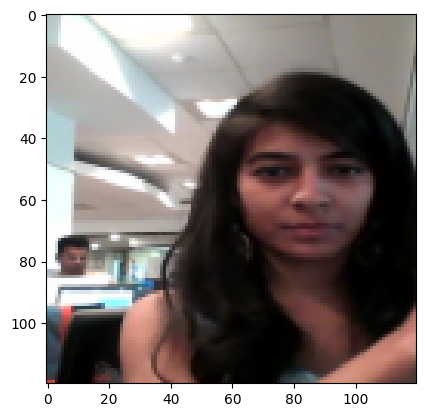

In [21]:
image = io.imread(img_file)
plt.imshow(image)
image = resize(image, (120, 160))
image = image[:,20:140]
plt.imshow(image)
#cropped_image = image[y1:y2, x1:x2]
#plt.imshow(cropped_image)
#cropped = image[x1:x2,y1:y2]

<Figure size 640x480 with 0 Axes>

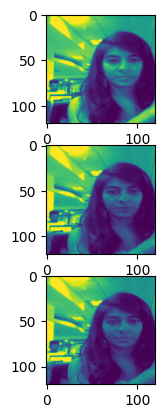

In [22]:
#from google.colab.patches import cv2_imshow
#image = resize(image, (128, 120))
#plt.imshow(image)
plt.figure()
f, axarr = plt.subplots(3,1) 

axarr[0].imshow(cv2.normalize(image[:,:,0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX))
axarr[1].imshow(cv2.normalize(image[:,:,1], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX))
axarr[2].imshow(cv2.normalize(image[:,:,2], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX))



C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//train/ 
 WIN_20180907_15_59_12_Pro_Stop Gesture_new;Stop Gesture_new;2 
 C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//train//WIN_20180907_15_59_12_Pro_Stop Gesture_new/WIN_20180907_15_59_12_Pro_00064.png


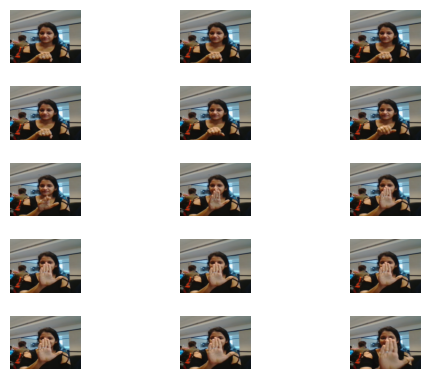

In [23]:
train_doc_inst = 12
step=2
imgs = os.listdir(train_path+'/'+ train_doc[train_doc_inst].split(",")[0].split(';')[0])
img_file = train_path+'/'+ train_doc[train_doc_inst].split(",")[0].split(';')[0]+'/'+imgs[25]
print(train_path, "\n", train_doc[train_doc_inst], "\n", img_file)
rows = 5
for x in range(math.floor(30/step)):
  index = x*step
  img_file = train_path+'/'+ train_doc[train_doc_inst].split(",")[0].split(';')[0]+'/'+imgs[index]
  image = io.imread(img_file)
  image = resize(image, (120, 160))
  normalized_image = cv2.normalize(image[:,:,0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

  plt.subplot(rows,6,index+1)
  #plt.title(x.split('.')[0])
  plt.axis('off')
  plt.imshow(image)

#plt.imshow(image)

#image = resize(image, (120, 128))
#plt.imshow(image)
#plt.show()


In [24]:
img_height = 120
img_width = 120
batch_size=5
x=30
y=img_height
z=img_width

In [50]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(30)] #[(x+1)*2 for x in range(14)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = math.floor(len(folder_list)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    image = resize(image, (120, 160)) #Only resizing to smaller size. No cropping applied as the image as slide left and right is covering the x-axis and thumbs-up, thumbs-down is covering y-axis
                    image = image[:,20:140] # cropped to consider only the center portion (120x120)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = cv2.normalize(image[:,:,0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
                    batch_data[folder,idx,:,:,1] = cv2.normalize(image[:,:,1], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
                    batch_data[folder,idx,:,:,2] = cv2.normalize(image[:,:,2], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        #last_batch_size = len(folder_list) - num_batches*batch_size
        #batch_data = np.zeros((last_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        #batch_labels = np.zeros((last_batch_size,5)) # batch_labels is the one hot representation of the output
        #last_batch_start_indx = num_batches*batch_size
        #for folder in range(last_batch_size): # iterate over the batch_size
        #        imgs = os.listdir(source_path+'/'+ t[folder + last_batch_start_indx].split(';')[0]) # read all the images in the folder
        #        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
        #            image = imageio.imread(source_path+'/'+ t[folder + last_batch_start_indx].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

        #            image = cv2.resize(img, (120, 128)) #Only resizing to smaller size. No cropping applied as the image as slide left and right is covering the x-axis and thumbs-up, thumbs-down is covering y-axis
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    #normalise and feed in the image
        #            batch_data[folder,idx,:,:,0] = cv2.normalize(image[:,:,0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        #            batch_data[folder,idx,:,:,1] = cv2.normalize(image[:,:,1], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        #            batch_data[folder,idx,:,:,2] = cv2.normalize(image[:,:,2], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        #       batch_labels[folder, int(t[folder + last_batch_start_indx].strip().split(';')[2])] = 1
        #yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [26]:
# Test generator function
print(train_path, train_doc, batch_size)
#print(val_path, val_doc, batch_size)
itr=0
for batch_data, batch_labels in generator(train_path, train_doc, batch_size):
#for batch_data, batch_labels in generator(val_path, val_doc, batch_size):
    print(batch_labels)
    itr=itr+1
    if itr == 4:
        break;
    


C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//train/ ['WIN_20180907_15_56_38_Pro_Right Swipe_new;Right Swipe_new;1'
 'WIN_20180907_15_57_30_Pro_Stop Gesture_new;Stop Gesture_new;2'
 'WIN_20180907_15_48_25_Pro_Thumbs Down_new;Thumbs Down_new;3'
 'WIN_20180907_15_55_22_Pro_Stop Gesture_new;Stop Gesture_new;2'
 'WIN_20180907_15_51_58_Pro_Right Swipe_new;Right Swipe_new;1'
 'WIN_20180907_15_39_51_Pro_Stop Gesture_new;Stop Gesture_new;2'
 'WIN_20180907_15_49_02_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0'
 'WIN_20180907_15_43_00_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0'
 'WIN_20180907_15_47_19_Pro_Thumbs Up_new;Thumbs Up_new;4'
 'WIN_20180907_15_57_35_Pro_Thumbs Up_new;Thumbs Up_new;4'
 'WIN_20180907_15_51_07_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0'
 'WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0'
 'WIN_20180907_15_59_

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [27]:
curr_dt_time = datetime.datetime.now()
#train_path = train_15_path #'/notebooks/storage/Final_data/Collated_training/train'
#val_path = val_15_path #'/notebooks/storage/Final_data/Collated_training/val'
print('# train_path =', train_path)
print('# val_path =', val_path)
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 1 # choose the number of epochs
print ('# epochs =', num_epochs)
img_height = 120
img_width = 120
print ('# image_size = %d,%d'%(img_height, img_width))
no_classes = 5
print ('# no_classes =', no_classes)


# train_path = C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//train/
# val_path = C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//val/
# training sequences = 57
# validation sequences = 13
# epochs = 1
# image_size = 120,120
# no_classes = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [28]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Reshape
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

In [45]:
#from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
#from keras.layers import Dense, Activation, Dropout, Conv2D, LSTM, MaxPooling2D, Flatten, BatchNormalization --> convolutional not supported

In [29]:
print(batch_size)

5


# **Conv3D without Drop-outs**

* training sequences = 58
* validation sequences = 14
* Batch-size = 5
* epochs = 1
* no_classes = 5
* image_size = 120,120
* Learning Rate = 0.1
* Optimizer = "Adam"
* Loss = "Cross Entropy"
* validation_split = 0.2
* verbosity = 1



In [42]:
batch_size=5
print(batch_size, x, y, z, 3)

5 30 120 120 3


In [43]:
#Write model using Conv3D and MaxPooling3D
conv3d_model = Sequential()
conv3d_model.add(Input((x, y, z, 3)))
#conv3d_model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(batch_size, img_height,img_width,3)))
conv3d_model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu'))
conv3d_model.add(BatchNormalization())
conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
conv3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
conv3d_model.add(BatchNormalization())
conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
conv3d_model.add(Flatten())
conv3d_model.add(Dense(32, activation='relu'))
conv3d_model.add(Dense(no_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [44]:
learning_rate = 0.1
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate) #write your optimizer
conv3d_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 28, 118, 118,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 118, 118,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 59, 59, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 57, 57, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 57, 57, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     4,816,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,832,453 (18.43 MB)

 Trainable params: 4,832,357 (18.43 MB)

 Non-trainable params: 96 (384.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [45]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [46]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(model_checkpoint_path+filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [47]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [48]:
print("num_train_sequences = %d, num_val_sequences = %d, batch_size = %d"%(num_train_sequences,num_val_sequences, batch_size))
print("# steps_per_epoch =", steps_per_epoch)
print("# validation_steps =", validation_steps)
print("# num_epochs =", num_epochs)

num_train_sequences = 57, num_val_sequences = 13, batch_size = 5
# steps_per_epoch = 12
# validation_steps = 3
# num_epochs = 1


In [55]:
#train_generator()

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [49]:
#conv3d_model.fit(train_generator, epochs=2, validation_data=val_generator, callbacks=callbacks_list)
conv3d_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps)#, initial_epoch=0)

Source path =  C:/Users/ukhan/Documents/Learning/Python/Jupyter/DeepLearning_CaseStudy_GuestureRecognition/Project_data//train/ ; batch size = 5
folder =  0
folder =  1
folder =  2
folder =  3
folder =  4
folder =  0
folder =  1
folder =  2
folder =  3
folder =  4
 1/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - categorical_accuracy: 0.0000e+00 - loss: 3.9520folder =  0
 2/12 ━━━━━━━━━━━━━━━━━━━━ 7s 751ms/step - categorical_accuracy: 0.0500 - loss: 772.4761folder =  1
folder =  2
folder =  3
folder =  4
folder =  0
 3/12 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - categorical_accuracy: 0.0556 - loss: 1111.1254 folder =  1
folder =  2
folder =  3
folder =  4
folder =  0
 4/12 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - categorical_accuracy: 0.0792 - loss: 1489.7844folder =  1
folder =  2
folder =  3
folder =  4
folder =  0
 5/12 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - categorical_accuracy: 0.1113 - loss: 1632.8550folder =  1
folder =  2
folder =  3
folder =  4
folder =  0
 6/12 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - cate

# Feed conv2D to RNN stack

In [52]:
cnn_rnn_model = Sequential()
#model.add(TimeDistributed(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'valid', input_shape = (1, n, m, 1))))
#model.add(TimeDistributed(MaxPooling2D(pool_size = (3,3))))
#model.add(TimeDistributed(Dropout(0.30)))
#model.add(TimeDistributed(Flatten()))
cnn_rnn_model.add(Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'valid', input_shape = (img_width, img_height, 3)))
cnn_rnn_model.add(BatchNormalization())
cnn_rnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_rnn_model.add(Dropout(0.30))
cnn_rnn_model.add(Reshape((32,-1)))
cnn_rnn_model.add(LSTM(units = 20, activation = 'relu', return_sequences = True))
##model.add(Dropout(0.1))
cnn_rnn_model.add(TimeDistributed(Dense(1, activation = 'relu')))


ValueError: The total size of the tensor must be unchanged, however, the input size cannot by divided by the specified dimensions in target_shape. Received: input_shape=(59, 59, 16), target_shape=(32, -1)

In [ ]:
optim = tf.keras.optimizers.Adam(lr = 0.1)
cnn_rnn_model.compile(optimizer = optim, loss = 'categorical_crossentropy', , metrics=['categorical_accuracy'])
print (cnn_rnn_model.summary())


In [ ]:
#cnn_rnn_model.fit(train_x, train_y, epochs = 10, batch_size = 1, verbose = 1)

In [ ]:
#train_generator = generator(train_path, train_doc, batch_size)
#val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
cnn_rnn_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)